# Неделя 10. Работа с несбалансированными данными

[Ссылка на гугл-форму для ответов](https://forms.gle/VthRvJUSMQr9TqRj9) 

Дедлайн: **02.05.20** включительно.

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import imblearn
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

### <font color='scarlett'> Для получения верных отвтеов необходимы следующие версии бибилотек:

print(sklearn.__version__)
print(imblearn.__version__)

0.21.3
0.4.3

## <font color="purple"> Загрузка данных

В используемом наборе данных собрана информация об оттоке клиентов телекоммуникационной компании.

__Задача__: определить лояльность клиента

    Признак "churn": 1 - перестал быть клиентом, 0 - продолжил пользоваться услугами компании
    
    Верно определяя абонентов, которые могут отказаться от услуг компании, бизнес может предпринять меры и минимизировать отток клиентов. Например, предлагать персональные скидки, предоставлять пакеты минут и т.п.

In [128]:
data = pd.read_csv("churn.csv")
data.shape

(3333, 21)

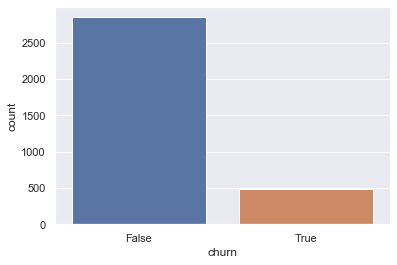

In [129]:
# посмотрим на распределение
sns.set(style="darkgrid")
sns.countplot(x="churn", data=data)

In [130]:
data['churn'].value_counts()

False    2850
True      483
Name: churn, dtype: int64

Очевидно, что большинство абонентов не отказываются от услуг. Компании необходимо разработать классификатор, находящий как можно больше редких недовольных клиентов. 

In [131]:
# уберем колонки Штат абонента, Тел.номер абонента
data.drop(['state','phone number'],axis=1,inplace=True)

In [132]:
# закодируем категориальные переменные
data["international plan"] = data["international plan"].map({"no":0,"yes":1})
data["voice mail plan"] = data["voice mail plan"].map({"no":0,"yes":1})

## <font color="purple"> Разделение выборки на обучение и контроль

Не забудем указать стратификацию по целевой переменной, чтобы сохранить исходное распределение классов.

In [133]:
train, test = train_test_split(data, test_size=0.2, stratify=data['churn'], random_state=1)
train.shape, test.shape

((2666, 19), (667, 19))

In [134]:
X_train = train.drop('churn', axis=1)
y_train = train['churn'].astype(int)

X_test = test.drop('churn', axis=1)
y_test = test['churn'].astype(int)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2666, 18), (2666,), (667, 18), (667,))

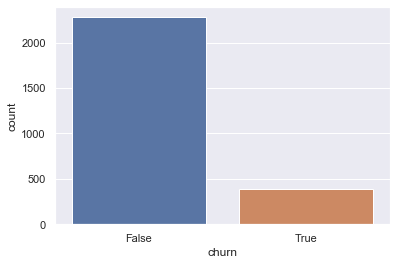

In [135]:
sns.countplot(x="churn", data=train)

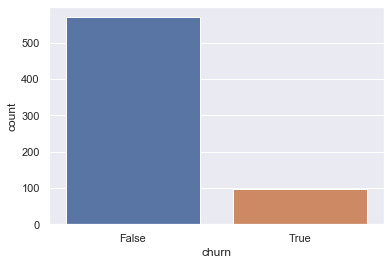

In [136]:
sns.countplot(x="churn", data=test)

## <font color="purple"> Кросс-валидация

### <font color='orange'> __Важно!__

Подбор оптимальной стратегии ресемплинга необходимо производить на кросс-валидации. Таким образом мы избежим подстраивания под данные тестовой выборки. Это позволит получить реалистичную оценку качества построенной модели.

### Задание 1. 

В качестве бейзлайна построим логистическую регрессию. 
1. Для оценки качества воспользуйтесь функцией cross_val_score из библиотеки sklearn.
    - Подумайте, какую стратегию кросс-валидации применить. Выберите нужную, укажите разбиение на 5 фолдов.
    - В качестве оцениваемой метрики выберите полноту.
    - Определите среднее значение, вовзращаемое функцией (используйте метод .mean()).
3. Ответ округлите до трех знаков после запятой. Внесите в гугл-форму __"Вопрос 1"__.

__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [137]:
#### ваш код ####
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

In [138]:
model = LogisticRegression(random_state=1)
kf = StratifiedKFold(n_splits=5, random_state=1)
results = cross_val_score(model, X_train, y_train, cv=kf, scoring='recall')
print(results)
round(np.mean(results), 3)

[0.14102564 0.14285714 0.27272727 0.22077922 0.18181818]


0.192

In [139]:
strategies = {
    'RandomOverSampler' : RandomOverSampler(sampling_strategy='minority', random_state=1).fit_sample(X_train, y_train),
    'SMOTE' : SMOTE(random_state=1).fit_sample(X_train, y_train),
    'RandomUnderSampler' : RandomUnderSampler(random_state=1).fit_sample(X_train, y_train),
    'NearMiss' : NearMiss(random_state=1).fit_sample(X_train, y_train),
    'TomekLinks': TomekLinks(random_state=1).fit_sample(X_train, y_train),
    'EditedNearestNeighbours' : EditedNearestNeighbours(random_state=1).fit_sample(X_train, y_train),
    'SMOTETomek' : SMOTETomek(random_state=1).fit_sample(X_train, y_train),
    'SMOTEENN' : SMOTEENN(random_state=1).fit_sample(X_train, y_train)
}

In [140]:
model = LogisticRegression(random_state=1)
scores = []
for strategie in strategies:
    x = strategies[strategie][0]
    y = strategies[strategie][1]
    result_cvs = cross_val_score(model, x, y, cv=5, scoring='recall')
    mean = np.mean(result_cvs)
    scores.append(round(mean,3))


In [141]:
max(scores)

0.877

Text(0.5, 1.0, 'cross_val_score for Resampling strategie')

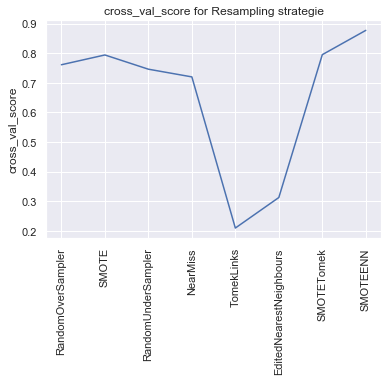

In [142]:
plt.xticks(rotation=90)
plt.plot(list(strategies.keys()), scores)
plt.ylabel('cross_val_score')
plt.title('cross_val_score for Resampling strategie')

### Задание 2.

1. Допишите функцию K-fold валидации (resamped_cv_scores), позволяющую произвести ресемплинг на K-1 фолдах, не затронув тестовый фолд. Функция принимает на вход объект алгоритма классификации, датафрейм признаков (независимых переменных), целевую переменную. Функция должна возвращать среднюю (используйте метод .mean()) оценку качества модели по всем K-фолдам.

2. В качестве алгоритма классификации используйте логистическую регрессию.

3. Ответ округлите до трех знаков после запятой. Внесите в гугл-форму __"Вопрос 2"__.

__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [143]:
def resamped_cv_scores(model, X, y):
    # Выбрать подходящий объект для кросс-валидации из классов sklearn.model_selection,
    # разбить выборку на 5 фолдов
    kfold = StratifiedKFold(n_splits=5, random_state=1)
    folds = list(kfold.split(X, y))
    #print(folds)
    
    train_folds, test_folds = [], []
    for fold in folds:
        
        #fold[0] - список индексов для train выборки
        #fold[1] - список индексов для test выборки
        
        X_train_fun, X_test_fun = X.iloc[fold[0]], X.iloc[fold[1]]
        y_train_fun, y_test_fun = y.iloc[fold[0]], y.iloc[fold[1]]
        
        #X_train_fun, X_test_fun = X.drop(labels=fold[1], axis=0), X.drop(labels=fold[0], axis=0)
        #y_train_fun, y_test_fun = y.drop(labels=fold[1], axis=0), y.drop(labels=fold[0], axis=0)
        train_folds.append([X_train_fun, y_train_fun])
        test_folds.append([X_test_fun, y_test_fun])
     
    
    #### ваш код ####
    
    # Выбрать алгоритм из библиотеки imblearn, производящий oversampling с 
    # последующим очищением с помощью алгоритма k-ближайших соседей.
    # Все параметры оставьте по умолчанию, кроме random_state.
    
    alg = SMOTEENN(random_state=1)
        
    #### ваш код #### 
    cv_scores = []
    for i in range(5):
        # Делаем ресемплинг на трейне
        X_resampled, y_resampled = alg.fit_sample(train_folds[i][0], train_folds[i][1])
    
        # Обучаем модель на данных трейна после ресемплинга
        model_obj = model.fit(X_resampled, y_resampled)
        
        # Оцениваем качество модели на тестовой выборке, не подвергавшейся ресемплингу
        # Необходимая нам метрика - полнота модели
        predicted = model_obj.predict(test_folds[i][0])
        cv_scores.append(recall_score(test_folds[i][1], predicted))
        
        #### ваш код ####
        
    return np.mean(cv_scores)

In [144]:
X_train = train.drop('churn', axis=1)
y_train = train['churn'].astype(int)

In [145]:
#### ваш код ####
X_data = data.drop('churn', axis=1)
y_data = data['churn'].astype(int)
model = LogisticRegression(random_state=1)
result_func = resamped_cv_scores(model, X_train, y_train)
round(result_func, 3)

0.826

## <font color="purple"> Немного теории

### Задание 3

В предыдущем задании вами была использована одна из модификаций метода oversampling с последующим удалением объектов, определяемых с помощью k-ближайших соседей. Кратко и точно объясните правило, по которому выбирались объекты для удаления __конкретно__ в нашем примере.


- Ответ внесите в гугл-форму __"Вопрос 3"__.

### Задание 4

На лекции мы познакомились с контролируемым методом undersampling'а - NearMiss. Мы разобрали работу одной из трех вариаций алгоритма. Кстати, именно ту, что заложена по умолчанию в библиотеки imblearn.

1. Кратко объясните, как работает NearMiss-2.
    - Ответ внесите в гугл-форму __"Вопрос 4.1"__.


2. Кратко объясните, как работает NearMiss-3.
    - Ответ внесите в гугл-форму __"Вопрос 4.2"__.

## <font color="purple"> Моделирование и тестирование

### Задание 5

На кросс-валидации мы убедились, что качество модели улучшается при использовании методов ресемплинга. Теперь мы построим модель и оценим качество классификации.

- Произведите ресемплинг обучающей выборки с помощью метода, использованного вами в __Задание 2__. На полученных данных обучите алгоритм логистической регрессии. Сделайте прогнозы на тестовой выборке.
- Отрисуйте матрицу ошибок с помощью функции draw_cm.
- Выведите classification_report для быстрой оценки метрик по обоим классам.

Вопросы:

1. Сколько __новых__ синтетических примеров было сгенерировано классом, который вы использовали для ресемплинга. 
    - Ответ запишите в гугл-форму __"Вопрос 5.1"__.
    
    
2. Как называются объекты указаные в левом нижнем углу и в правом верхнем углу матрицы ошибок? Попробуйте поиграть с параметром normalize. Обратите внимание на подписи к осям.
    - Ответ запишите в гугл-форму __"Вопрос 5.2"__.
    
    
3. Какую из четырех категорий хочет минимизировать телекоммуникационная компания, если хочет сохранить как можно больше клиентов? Какую максимизировать?
    - Ответ запишите в гугл-форму __"Вопрос 5.3"__.
    
    
__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [146]:
from sklearn.metrics import classification_report, confusion_matrix

In [147]:
def draw_cm(cm, classes, normalize=True):
    """
    Функция для отрисовки матрицы ошибок
        cm: Матрица ошибок
        classes: список классов
    """
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (6,5))
    
    if normalize:
        df_cm = pd.DataFrame(cm_norm, index = [i for i in classes],
                             columns = [i for i in classes])
        sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='.2g')
    else:
        df_cm = pd.DataFrame(cm, index = [i for i in classes],
                         columns = [i for i in classes])
        sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
        
    plt.title('Матрица ошибок', fontsize=15)
    plt.xlabel('Истинный класс', fontsize=12)
    plt.ylabel('Предсказанный класс', fontsize=12)

In [148]:
#### ваш код ####
model = LogisticRegression(random_state=1) 
X_resampled, y_resampled = SMOTEENN(random_state=1).fit_sample(X_train, y_train)
model.fit(X_resampled, y_resampled)
predicted = model.predict(X_test)

In [149]:
X_train.shape, y_train.shape

((2666, 18), (2666,))

In [150]:
X_resampled.shape[0] - X_train.shape[0]

784

              precision    recall  f1-score   support

           0       0.96      0.66      0.78       570
           1       0.29      0.82      0.43        97

    accuracy                           0.68       667
   macro avg       0.62      0.74      0.61       667
weighted avg       0.86      0.68      0.73       667

[[376 194]
 [ 17  80]]
0.825


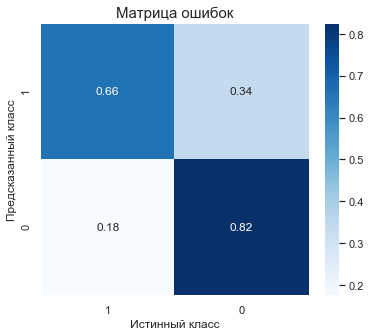

In [151]:
cl_report = classification_report(y_test, predicted)
print(cl_report)
cm = confusion_matrix(y_test, predicted)
print(cm)
print(round(recall_score(y_test, predicted), 3))
draw_cm(cm, [1, 0])

## <font color="purple"> Обучение ансамблей на сбалансированных подвыборках

### Задание 6

Библиотека imblearn также предоставляет возможность обучения ансамблей на сбалансированных подвыборках. Примером может служить класс BalancedRandomForestClassifier.

1. Кратко опишите, как работает реализация данного класса.
    - Ответ запишите в гугл-форму __"Вопрос 6.1"__


2. Импортируйте класс в ноутбук и постройте с его помощью классификатор. 
        - Все параметры оставьте по умолчанию, кроме двух: глубину дерева установите равной 3, random_state=1.
        - Создайте прогнозы на тестовой выборке.
        - Отрисуйте матрицу ошибок с помощью функции draw_cm.
        - Выведите classification_report для быстрой оценки метрик по обоим классам.

3. Оцените полноту модели. Ответ округлите до трех знаков после запятой.
    - Ответ запишите в гугл-форму __"Вопрос 6.2"__
    
    
4. Исследуйте созданный вами classification_report. По сравнению с моделью в __Задании 5__ увеличилась ли полнота мажорного класа, минорного класса или обоих классов??
    - Ответ запишите в гугл-форму __"Вопрос 6.3"__
    
__NB__: Для воспроизводимости результатов и получения правильного ответа __во всех алгоритмах и методах__ нужно установить параметр random_seed=1!

In [152]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [153]:
#### ваш код ####

In [154]:
alg = BalancedRandomForestClassifier(max_depth=3, random_state=1)
alg.fit(X_train, y_train)
predicted = alg.predict(X_test)

In [155]:
X_train.shape, y_train.shape

((2666, 18), (2666,))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       570
           1       0.55      0.85      0.66        97

    accuracy                           0.88       667
   macro avg       0.76      0.86      0.79       667
weighted avg       0.91      0.88      0.89       667

[[502  68]
 [ 15  82]]
0.845


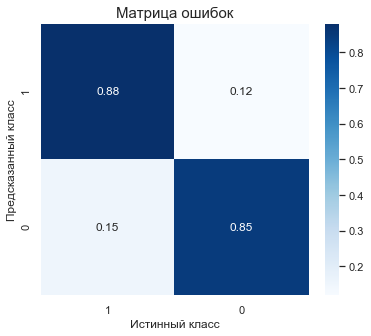

In [156]:
cl_report = classification_report(y_test, predicted)
print(cl_report)
cm = confusion_matrix(y_test, predicted)
print(cm)
print(round(recall_score(y_test, predicted), 3))
draw_cm(cm, [1, 0])